#### The goal of this project file is to predict flow using ppt data

Version 3: 
- predict all subwatersheds flow in 2018
- used '#' to skip random grid model to save processing time. The base model appears to perform well.
- I accidentally included 2018 data in the training dataset, which caused the predicted 2018 values to be very accurate. This version only uses 2015-17 data to train.
- also used '#' to skip "Avg ISCO sample flow' prediction because it was kinda useless

In [2]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pprint import pprint

%matplotlib inline

In [3]:
# importing flow dataset
df_flow = pd.read_excel('Daily ISCO flow and precipitation.xlsx', sheet_name = 'Sheet1')


df_flow = df_flow.drop(columns=['Daily precip (in)','Daily precip (mm)','S12-ISCO flow (cms)','T12-ISCO flow (cms)'])

df_flow = df_flow.rename(columns={'T8-ISCO flow (cms)':'Flow8', 'S11-ISCO flow (cms)':'Flow11', 'S12+T12':'Flow12'})

#df_flow = pd.DataFrame(df_flow, columns=['Sample date', 'Sample type', 'Site', 'Flow'])
#df_flow.describe()

In [4]:
# importing weather dataset
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather = df_weather.rename(columns={'ppt (mm)':'ppt','tmin (degrees C)':'tmin','tmean (degrees C)':'tmean',
                                        'tmax (degrees C)':'tmax', 'tdmean (degrees C)':'tdew', 'vpdmin (hPa)': 'vpdmin', 
                                        'vpdmax (hPa)': 'vpdmax'})

df_weather['Year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather['Month'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['Day'] = pd.DatetimeIndex(df_weather['Date']).day
df_weather['Day of year'] = df_weather['Date'].dt.dayofyear

# calculate antecedent ppt and temperature
# 2-day antecedent cumulative ppt (mm)
df_weather['2-day ppt'] = round(df_weather.iloc[:,1].rolling(window=2).sum(), 1)

# 3-day antecedent cumulative ppt (mm)
df_weather['3-day ppt'] = round(df_weather.iloc[:,1].rolling(window=3).sum(), 1)

# 5-day antecedent cumulative ppt (mm)
df_weather['5-day ppt'] = round(df_weather.iloc[:,1].rolling(window=5).sum(), 1)

# 7-day antecedent cumulative ppt (mm)
df_weather['7-day ppt'] = round(df_weather.iloc[:,1].rolling(window=7).sum(), 1)

# 15-day antecedent cumulative ppt (mm)
df_weather['15-day ppt'] = round(df_weather.iloc[:,1].rolling(window=15).sum(), 1)

# 30-day antecedent cumulative ppt (mm)
df_weather['30-day ppt'] = round(df_weather.iloc[:,1].rolling(window=30).sum(), 1)

# 90-day antecedent cumulative ppt (mm)
df_weather['90-day ppt'] = round(df_weather.iloc[:,1].rolling(window=90).sum(), 1)

# 180-day antecedent cumulative ppt (mm)
df_weather['180-day ppt'] = round(df_weather.iloc[:,1].rolling(window=180).sum(), 1)

# 360-day antecedent cumulative ppt (mm)
df_weather['360-day ppt'] = round(df_weather.iloc[:,1].rolling(window=360).sum(), 1)


# 2-day antecedent avg temperature (ºC)
df_weather['2-day temp'] = round(df_weather.iloc[:,3].rolling(window=2).mean(), 1)

# 3-day antecedent avg temperature (ºC)
df_weather['3-day temp'] = round(df_weather.iloc[:,3].rolling(window=3).mean(), 1)

# 5-day antecedent avg temperature (ºC)
df_weather['5-day temp'] = round(df_weather.iloc[:,3].rolling(window=5).mean(), 1)

# 7-day antecedent avg temperature (ºC)
df_weather['7-day temp'] = round(df_weather.iloc[:,3].rolling(window=7).mean(), 1)

# 15-day antecedent avg temperature (ºC)
df_weather['15-day temp'] = round(df_weather.iloc[:,3].rolling(window=15).mean(), 1)

# 30-day antecedent avg temperature (ºC)
df_weather['30-day temp'] = round(df_weather.iloc[:,3].rolling(window=30).mean(), 1)

df_weather = df_weather.drop(columns=['tmin','tmax','tdew','vpdmin','vpdmax'])
df_train = df_weather[df_weather["Year"].isin([2015, 2016, 2017])]

#df_weather.head()

# merging flow and weather datasets
df_merged = pd.merge(df_train, df_flow, left_on='Date', right_on='Date', how='right')
df_merged = df_merged.dropna()

writer = pd.ExcelWriter('weather_test.xlsx')
# write dataframe to excel
df_merged.to_excel(writer)
# save the excel
writer.save()

#df_merged.tail()
#df_merged.describe()

### Training random forest to predict flow using weather data - base model

training period explained variance: 0.8326722347935779
training period mean abs error: 0.017115807392727167
training period mean squared error: 0.0017075959189403506
training period r2: 0.8278316152525205


Text(0.5, 1.0, 'Feature importance')

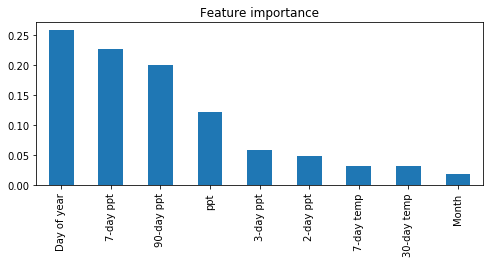

In [27]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_merged['Date'] = pd.to_numeric(pd.to_datetime(df_merged['Date']))

# implement random forest
from sklearn.model_selection import train_test_split

# change the input parameters (i.e., predictors) here 
predictors = ['Day of year', 'Month', 'ppt', '2-day ppt', '3-day ppt', '7-day ppt', '90-day ppt', '7-day temp', '30-day temp']
X = df_merged[predictors]

# change the output parameters (i.e., sub8 flow, sub11 flow, sub12 flow) here 
sub = 'Flow8'
y = df_merged[sub]

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.2, random_state = 0)

rf_base = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)

rf_base.fit(X_train, Y_train)

Y_pred = rf_base.predict(X_test)

print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
print('training period r2:',r2_score(Y_test, Y_pred))

fet_ind = np.argsort(rf_base.feature_importances_)[::-1]
fet_imp = rf_base.feature_importances_[np.argsort(rf_base.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')

## Predict 2018 daily data, compare with ISCO data

C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


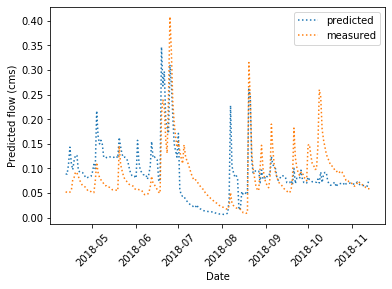

prediction period explained variance: 0.2715433080221398
prediction period mean abs error: 0.03851295844839999
prediction period mean squared error: 0.002370155034945121
prediction period r2: 0.2676795885625315


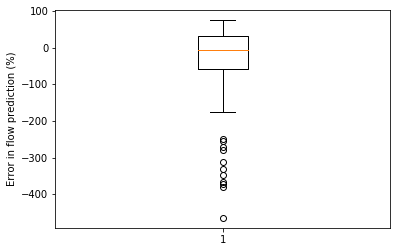

Average error: -25.34
Median error: -7.0


In [28]:
df_weathersub = df_weather[df_weather["Year"].isin([2018])]
df_weathersub = df_weathersub.reset_index(drop=True)
df_test = df_weathersub
df_test = df_test[predictors]
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)

# If 'Date' variable is present, convert the date from timestamp to numeric because sklearn cannot process timestamp format
#df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))

# use base or random depending on model performance
#Y_pred = rf_base.predict(df_test)
Y_pred = rf_base.predict(df_test)


df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)
df_predict = pd.merge(df_weathersub['Date'], df_predict, left_index=True, right_index=True)

#df_predict['Date'] = pd.to_datetime(df_predict['Date'])

# this is ISCO daily avg flow
df_actual = df_flow[['Date', sub]]
df_actual['Year'] = pd.DatetimeIndex(df_actual['Date']).year
df_actual = df_actual[df_actual["Year"].isin([2018])]
df_actual = df_actual.dropna()

df_predict = pd.merge(df_predict, df_actual, left_on='Date', right_on='Date', how='right')
df_predict['error (%)'] = round(((df_predict[sub]-df_predict['flow_pred'])/df_predict[sub]*100), 0)

plt.plot(df_predict['Date'], df_predict['flow_pred'], linestyle = 'dotted', label='predicted')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.plot(df_predict['Date'], df_predict[sub], linestyle = 'dotted', label='measured')
plt.ylabel('Predicted flow (cms)')
plt.legend()
plt.show()

print('prediction period explained variance:',explained_variance_score(df_predict[sub], df_predict['flow_pred']))
print('prediction period mean abs error:',mean_absolute_error(df_predict[sub], df_predict['flow_pred']))
print('prediction period mean squared error:',mean_squared_error(df_predict[sub], df_predict['flow_pred']))
print('prediction period r2:',r2_score(df_predict[sub], df_predict['flow_pred']))

writer = pd.ExcelWriter('predict flow 2018 daily.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()

plt.boxplot(df_predict['error (%)'])
plt.ylabel('Error in flow prediction (%)')
plt.show()

print('Average error:', round(df_predict['error (%)'].mean(),2))
print('Median error:', round(df_predict['error (%)'].median(),2))

### Using random grid model to improve base model

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# the values below are somewhat selected arbitarily to cover a wide range of parameters

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

#pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
#rf = ske.RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = 1)
# Fit the random search model
#rf_random.fit(X_train, Y_train)

In [ ]:
#Y_pred = rf_random.predict(X_test)

#print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
#print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
#print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
#print('training period r2:',r2_score(Y_test, Y_pred))

In [ ]:
#def evaluate(model, X_train, Y_train):
#    predictions = model.predict(X_train)
#    errors = abs(predictions - Y_train)
#    mape = 100 * np.mean(errors / Y_train)
#    accuracy = 100 - mape
#    print('Model Performance')
#    print('Average Error: {:0.4f} cms.'.format(np.mean(errors)))
#    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#    return accuracy

#class color:
#    BLUE = '\033[94m'
#    BOLD = '\033[1m'
#    END = '\033[0m'

#print(color.BOLD + color.BLUE + 'For Base Model' + color.END)
#base_accuracy = evaluate(rf_base, X_train, Y_train)

#print(color.BOLD + color.BLUE + 'For Random Model' + color.END)
#best_random = rf_random.best_estimator_
#random_accuracy = evaluate(best_random, X_train, Y_train)

#print(color.BOLD + color.BLUE + 'Base vs random model comparison' + color.END)
#print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

#pprint(rf_random.best_params_)

In [ ]:
#from sklearn.model_selection import GridSearchCV

# if the random model performed better than the base model, then use the best random grid to create range of each hyperparameter

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
#max_features = ['sqrt']

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
#min_samples_split = [2, 3, 4]

# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
#bootstrap = [False]

# Create the better grid
#better_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

# We used randamized search to identify the better grid (i.e., narrow down the range for each hyperparameter)
# Now we use the better grid to instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = better_grid, 
#                          cv = 3, n_jobs = 1, verbose = 2)


In [ ]:
# Fit the grid search to the data
#grid_search.fit(X_train, Y_train)
#grid_search.best_params_

#best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_train, Y_train)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [ ]:
#Y_pred = rf_random.predict(X_test)

#print('training period explained variance:', explained_variance_score(Y_test, Y_pred))
#print('training period mean abs error:',mean_absolute_error(Y_test, Y_pred))
#print('training period mean squared error:',mean_squared_error(Y_test, Y_pred))
#print('training period r2:',r2_score(Y_test, Y_pred))

## Predict 2018 data, then compare against actual sample avg flow data

In [ ]:
#df_test = df_weather[df_weather["Year"].isin([2018])]
#df_test = df_test.reset_index(drop=True)
#df_test = pd.merge(df_weather, df_testraw, left_on='Date', right_on='Sample date', how='inner')

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
#df_test['Date'] = pd.to_numeric(pd.to_datetime(df_test['Date']))
#df_test = df_test[predictors]

# use base or random depending on model performance
#Y_pred = rf_base.predict(df_test)
#Y_pred = rf_random.predict(df_test)

#df_predict = pd.DataFrame(Y_pred, columns=['flow_pred'])
#df_predict = pd.merge(df_test, df_predict, left_index=True, right_index=True)

# this is flow-weighted sample avg flow
#df_actual = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed')
#df_actual = df_actual[(df_actual['Site'] == 'Sub8') & (df_actual['Sample type'] == 'Base')]
#df_actual = df_actual[['Sample date','Flow (cms)']]
#df_actual = df_actual.dropna()

#df_predict = pd.merge(df_actual, df_predict['flow_pred'], left_index=True, right_index=True)
#df_predict['error (%)'] = round(((df_predict['Flow (cms)']-df_predict['flow_pred'])/df_predict['Flow (cms)']*100), 0)

#df_predict['Sample date'] = pd.to_datetime(df_predict['Sample date'])

#print('prediction period explained variance:',explained_variance_score(df_predict['Flow (cms)'], df_predict['flow_pred']))
#print('prediction period mean abs error:',mean_absolute_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
#print('prediction period mean squared error:',mean_squared_error(df_predict['Flow (cms)'], df_predict['flow_pred']))
#print('prediction period r2:',r2_score(df_predict['Flow (cms)'], df_predict['flow_pred']))

#plt.scatter(df_predict['Flow (cms)'], df_predict['flow_pred'])
#plt.xlabel('Actual flow (cms)')
#plt.ylabel('Predicted flow (cms)')

In [ ]:
#writer = pd.ExcelWriter('predict flow 2018.xlsx')
# write dataframe to excel
#df_predict.to_excel(writer)
# save the excel
#writer.save()